<a href="https://colab.research.google.com/github/liyanalukman/Forecasting-Tourist-Arrivals-Trends/blob/master/Data_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run this cell first, then click runtime -> restart session, click next cell and runtime -> run cell and below
!pip uninstall -y xgboost
!pip install xgboost==1.7.6

Found existing installation: xgboost 2.1.4
Uninstalling xgboost-2.1.4:
  Successfully uninstalled xgboost-2.1.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 4.6 MB/s eta 0:00:00


In [ ]:
# Check XGBoost version
import xgboost
print(xgboost.__version__)

1.7.6


**Import Dataset & necessary libraries**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_digits
from sklearn import preprocessing
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from datetime import datetime

# Import dataset
df = pd.read_csv("arrivals_soe.csv")

# Take a glance at first 5 rows
df.head(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92674 entries, 0 to 92673
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             92674 non-null  object
 1   country          92674 non-null  object
 2   soe              92674 non-null  object
 3   arrivals         92674 non-null  int64 
 4   arrivals_male    92674 non-null  int64 
 5   arrivals_female  92674 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 4.2+ MB


**Pre-processing dataset**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])

# Filter country-state pairs with very low total arrivals
total_arrivals_by_country_state = df.groupby(['country', 'soe'])['arrivals'].sum().reset_index()
valid_pairs = total_arrivals_by_country_state[total_arrivals_by_country_state['arrivals'] > 1000]
df = df.merge(valid_pairs[['country', 'soe']], on=['country', 'soe'], how='inner')

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Log-transform target to stabilize variance
df['log_arrivals'] = np.log1p(df['arrivals'])

# Encode categorical variables
le_country = LabelEncoder()
df['country_enc'] = le_country.fit_transform(df['country'])

le_state = LabelEncoder()
df['state_enc'] = le_state.fit_transform(df['soe'])

# Sort for lag creation
df = df.sort_values(['country', 'soe', 'date'])
df['month_count'] = (df['year'] - df['year'].min()) * 12 + df['month']

# Create lag features on log scale
df['lag1_log'] = df.groupby(['country', 'soe'])['log_arrivals'].shift(1)
df['lag2_log'] = df.groupby(['country', 'soe'])['log_arrivals'].shift(2)
df['lag3_log'] = df.groupby(['country', 'soe'])['log_arrivals'].shift(3)

group_counts = df.groupby(['country', 'soe']).size()
valid_groups = group_counts[group_counts >= 6].index
df = df[df.set_index(['country', 'soe']).index.isin(valid_groups)]

print(f"Initial rows: {len(df)}")

# Drop rows with NaN in lag features
df = df.dropna(subset=['lag1_log', 'lag2_log', 'lag3_log'])
print(f"Rows after dropna: {len(df)}")

# Cyclic encoding for month (seasonality)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Define features and target
features = ['month_count','month_sin', 'month_cos', 'country_enc', 'state_enc', 'lag1_log', 'lag2_log', 'lag3_log']
target = 'log_arrivals'

# Train/test split by date, train < 2024, test >= 2024
train_df = df[df['date'] < '2024-01-01']
test_df = df[df['date'] >= '2024-01-01']

# Train/Test data to be used is in Log
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]


Initial rows: 23302
Rows after dropna: 22096


**Define Evaluation and Plotting function**

*   Aggregation of total arrivals in a month
*   Plotting of arrivals
*   Comparison of monthly arrivals
*   Metrics calculation in actual form (exponentiate)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, mean_squared_log_error

def evaluate_and_plot(test_df, pred, y_true, start_date='2024-01-01', end_date='2024-10-31'):
    test_df = test_df.copy()

    # Inverse transform predictions and true values
    pred = np.expm1(pred)
    y_true = np.expm1(y_true)

    test_df['predicted_arrivals'] = pred
    test_df['actual_arrivals'] = y_true

    # Filter by date range
    test_eval_df = test_df[(test_df['date'] >= start_date) & (test_df['date'] <= end_date)]

    # Aggregate total arrivals per month (sum over all countries/states)
    agg_actual = test_eval_df.groupby('date')['actual_arrivals'].sum()
    agg_pred = test_eval_df.groupby('date')['predicted_arrivals'].sum()

    # Calculate metrics
    rmse_eval = np.sqrt(mean_squared_error(agg_actual, agg_pred))
    mae = mean_absolute_error(agg_actual, agg_pred)
    mape = np.mean(np.abs((agg_actual - agg_pred) / agg_actual)) * 100
    r2 = r2_score(agg_actual, agg_pred)
    medae = median_absolute_error(agg_actual, agg_pred)
    msle = mean_squared_log_error(agg_actual, agg_pred)
    rmsle = np.sqrt(msle)

    # Plot results
    plt.figure(figsize=(12,6))
    plt.plot(agg_actual.index, agg_actual.values, label='Actual Total Arrivals', marker='o')
    plt.plot(agg_pred.index, agg_pred.values, label='Predicted Total Arrivals', marker='x')
    plt.title(f'Total Monthly Arrivals: Actual vs Predicted ({start_date} to {end_date})')
    plt.xlabel('Date')
    plt.ylabel('Number of Arrivals')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Summary table
    comparison_df = pd.DataFrame({
        'Month': agg_actual.index.strftime('%b'),
        'Actual_Arrivals': agg_actual.values,
        'Predicted_Arrivals': agg_pred.values.round().astype(int)
    })

    # Print metrics
    print("\n=== Evaluation Metrics ===")
    print(f"RMSE: {rmse_eval:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"Median AE      : {medae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R² Score       : {r2:.4f}")
    print(f"RMSLE           : {rmsle:.4f}")
    print("\n=== Month-wise Actual vs Predicted Total Arrivals ===")
    print(comparison_df.to_string(index=False))


**Model 1 (XGBoost)**

*   Initial modelling using XGBoost, without tuning with parameters
*   Training data

>> Basic XGBoost Model


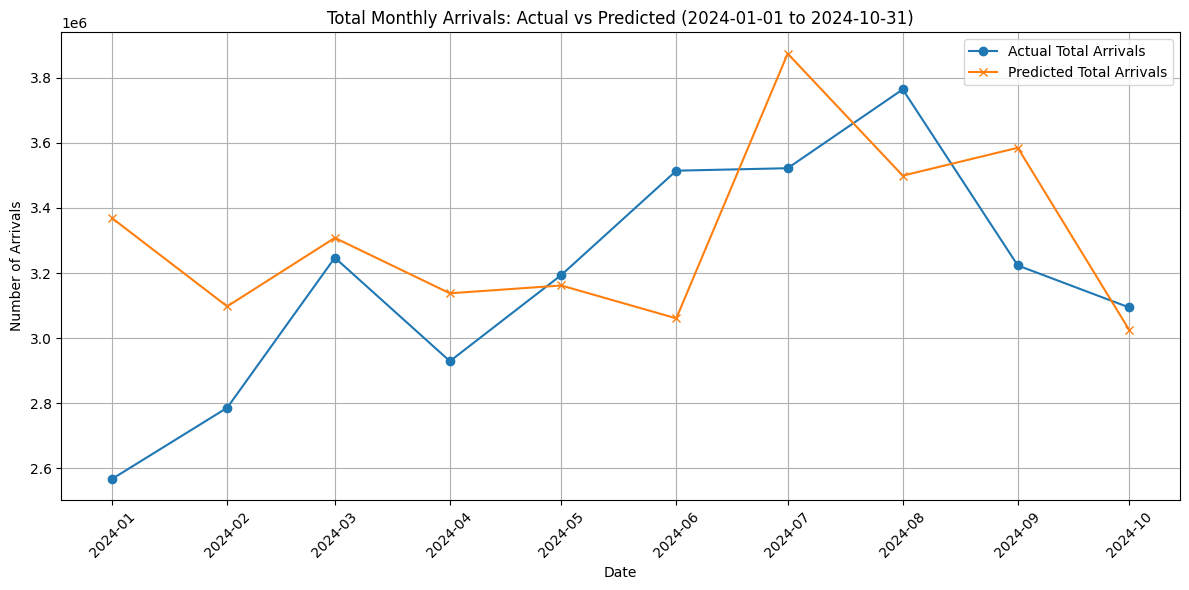


=== Evaluation Metrics ===
RMSE: 363559.43
MAE : 291444.62
Median AE      : 288196.50
MAPE: 9.57%
R² Score       : -0.1234
RMSLE           : 0.1164

=== Month-wise Actual vs Predicted Total Arrivals ===
Month  Actual_Arrivals  Predicted_Arrivals
  Jan        2567639.0             3368428
  Feb        2786137.0             3097596
  Mar        3247101.0             3308003
  Apr        2929205.0             3137715
  May        3193704.0             3161756
  Jun        3514361.0             3060783
  Jul        3521942.0             3874013
  Aug        3764066.0             3499132
  Sep        3223216.0             3584703
  Oct        3094268.0             3025500


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Basic Model
xgb_basic = XGBRegressor(
    n_estimators=100,
    random_state=42
)
# Model fitting
xgb_basic.fit(X_train, y_train)

# Predicting arrivals
pred_basic_log = xgb_basic.predict(X_test)

print(">> Basic XGBoost Model")
evaluate_and_plot(test_df, pred_basic_log, y_test)

**Tuning XGBoost with hyperparameter**

Finding best parameter manually

In [ ]:
# Takes time to run
'''from xgboost import XGBRegressor
import numpy as np
import itertools
from sklearn.metrics import mean_squared_error

# Split train/validation to choose the best parameter
train_split = train_df[train_df['date'] < '2023-07-01']
val_split = train_df[train_df['date'] >= '2023-07-01']

X_train_split = train_split[features]
y_train_split = train_split[target]

X_val_split = val_split[features]
y_val_split = val_split[target]

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Get all combinations
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_rmse = float('inf')
best_params = None

# Loop through parameter combinations
for params in combinations:
    model = XGBRegressor(objective='reg:squarederror', random_state=42, **params)
    model.fit(X_train_split, y_train_split)

    val_preds_log = model.predict(X_val_split)

    # Create a copy of val_split to hold predictions
    val_df = val_split.copy()
    val_df['predicted'] = np.expm1(val_preds_log)
    val_df['actual'] = np.expm1(y_val_split.values)  # Ensure matching values

    # Group by date and sum (like evaluate_and_plot function)
    agg_pred = val_df.groupby('date')['predicted'].sum()
    agg_actual = val_df.groupby('date')['actual'].sum()

    # Calculate RMSE for comparison
    rmse = np.sqrt(mean_squared_error(agg_actual, agg_pred))

    # Track best parameters
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print("Best parameters found: ", best_params)
print("Best RMSE (monthly total): ", best_rmse)
'''
# result
# Best parameters found:  {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 1.0}
# Best RMSE (monthly total):  348785.5344257061


'from xgboost import XGBRegressor\nimport numpy as np\nimport itertools\nfrom sklearn.metrics import mean_squared_error\n\n# Split train/validation to choose the best parameter\ntrain_split = train_df[train_df[\'date\'] < \'2023-07-01\']\nval_split = train_df[train_df[\'date\'] >= \'2023-07-01\']\n\nX_train_split = train_split[features]\ny_train_split = train_split[target]\n\nX_val_split = val_split[features]\ny_val_split = val_split[target]\n\n# Define parameter grid\nparam_grid = {\n    \'n_estimators\': [100, 200, 300, 400],\n    \'max_depth\': [5, 7, 9],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'subsample\': [0.8, 1.0]\n}\n\n# Get all combinations\nkeys, values = zip(*param_grid.items())\ncombinations = [dict(zip(keys, v)) for v in itertools.product(*values)]\n\nbest_rmse = float(\'inf\')\nbest_params = None\n\n# Loop through parameter combinations\nfor params in combinations:\n    model = XGBRegressor(objective=\'reg:squarederror\', random_state=42, **params)\n    model.fi

Tuning with best parameters

>> Tuned XGBoost Model


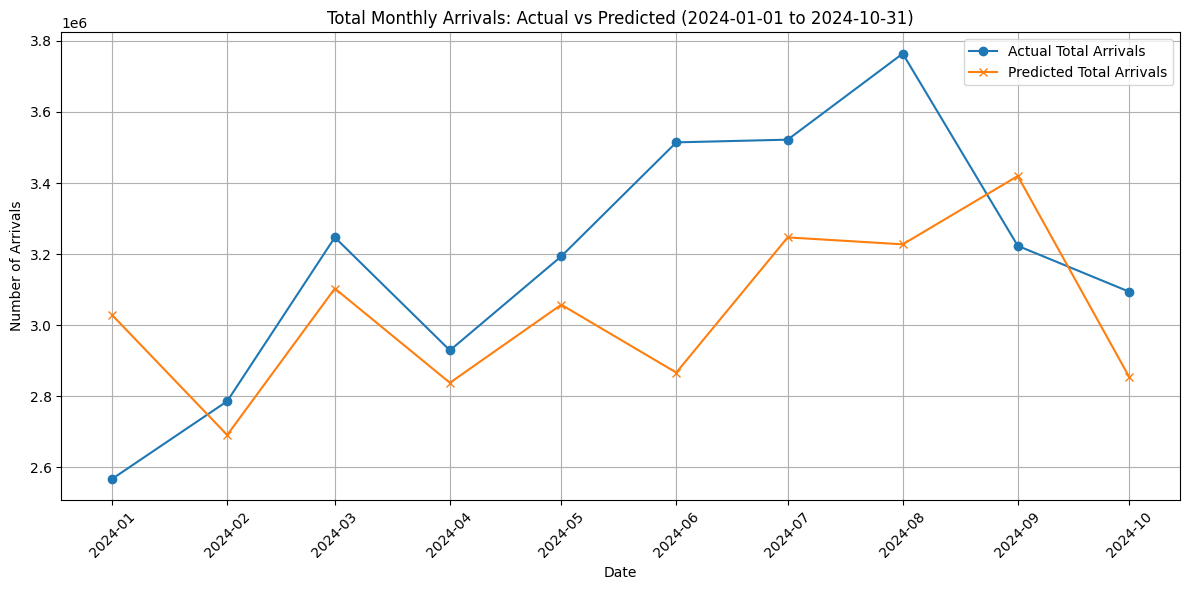


=== Evaluation Metrics ===
RMSE: 338823.35
MAE : 282225.40
Median AE      : 218053.75
MAPE: 8.75%
R² Score       : 0.0243
RMSLE           : 0.1073

=== Month-wise Actual vs Predicted Total Arrivals ===
Month  Actual_Arrivals  Predicted_Arrivals
  Jan        2567639.0             3028647
  Feb        2786137.0             2691157
  Mar        3247101.0             3103228
  Apr        2929205.0             2838064
  May        3193704.0             3057679
  Jun        3514361.0             2866710
  Jul        3521942.0             3247038
  Aug        3764066.0             3227502
  Sep        3223216.0             3419663
  Oct        3094268.0             2854608


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Tuned Model
xgb_tuned = XGBRegressor(objective='reg:squarederror',
                         random_state=42,
                         n_estimators=400,
                         max_depth=7,
                         learning_rate=0.1,
                         subsample=1.0
                          )

# If previous code is run
# xgb_tuned = XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)

# Model fitting
xgb_tuned.fit(X_train, y_train)

#Predicting arrivals
pred_tuned_log = xgb_tuned.predict(X_test)

print(">> Tuned XGBoost Model")
evaluate_and_plot(test_df, pred_tuned_log, y_test)

**Model 2 (LightGBM)**



*   Initial modelling, without tuning with hyperparameters



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 976
[LightGBM] [Info] Number of data points in the train set: 18089, number of used features: 8
[LightGBM] [Info] Start training from score 3.133705
>> Basic LightGBM Model


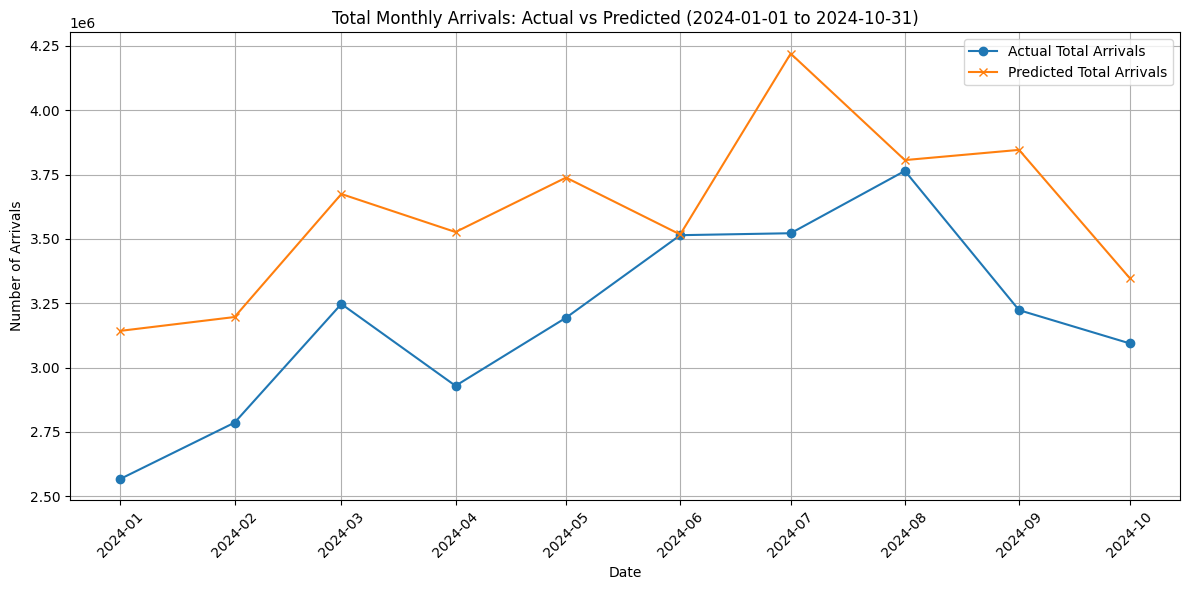


=== Evaluation Metrics ===
RMSE: 477035.28
MAE : 417351.78
Median AE      : 485812.25
MAPE: 13.63%
R² Score       : -0.9341
RMSLE           : 0.1430

=== Month-wise Actual vs Predicted Total Arrivals ===
Month  Actual_Arrivals  Predicted_Arrivals
  Jan        2567639.0             3142712
  Feb        2786137.0             3196412
  Mar        3247101.0             3674315
  Apr        2929205.0             3526644
  May        3193704.0             3738114
  Jun        3514361.0             3517077
  Jul        3521942.0             4219742
  Aug        3764066.0             3806062
  Sep        3223216.0             3845713
  Oct        3094268.0             3348366


In [ ]:
from lightgbm import LGBMRegressor

# LightGBM Basic Model
lgb_basic = LGBMRegressor(random_state=42)

# Model fitting
lgb_basic.fit(X_train, y_train)

#Predicting arrivals
pred_log = lgb_basic.predict(X_test)

print(">> Basic LightGBM Model")
evaluate_and_plot(test_df, pred_log, y_test)

**Tuning LightGBM with hyperparameter**

Finding best parameters using RandomizedSearch

In [ ]:
# Randomized Searching will give different param everytime
# Some better some worse than basic model
'''
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

# Custom scorer that groups by date and computes RMSE on aggregated sums
def grouped_rmse(estimator, X_val, y_val):
    y_pred_log = estimator.predict(X_val)
    val_df = X_val.copy()
    val_df['predicted'] = np.expm1(y_pred_log)
    val_df['actual'] = np.expm1(y_val)

    # Aggregate by date (assuming 'date' column in val_df)
    agg_pred = val_df.groupby('date')['predicted'].sum()
    agg_actual = val_df.groupby('date')['actual'].sum()

    rmse = np.sqrt(mean_squared_error(agg_actual, agg_pred))
    return -rmse

# Wrap scorer (greater_is_better=False means lower RMSE is better)
custom_scorer = make_scorer(grouped_rmse, greater_is_better=False)

# Define param grid to search
param_grid = {
    'num_leaves': [15, 31, 50],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [10, 20, 30]
}

# Drop 'date' before training features but keep for scorer
X_train_no_date = train_df.drop(columns=['date', 'country','soe'])

model = LGBMRegressor()
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,
    scoring=custom_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Model fitting to the parameter
search.fit(X_train_no_date, y_train)

print("Best parameters found:", search.best_params_)
print("Best grouped RMSE (negative):", search.best_score_)
'''
# Result will differ each runtime
# One of the best params
# subsample=0.6, num_leaves=31, n_estimators= 500, min_child_samples=5, max_depth=10, learning_rate=0.03, colsample_bytree=0.8

'\nimport numpy as np\nimport pandas as pd\nfrom lightgbm import LGBMRegressor\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.metrics import mean_squared_error, make_scorer\n\n# Custom scorer that groups by date and computes RMSE on aggregated sums\ndef grouped_rmse(estimator, X_val, y_val):\n    y_pred_log = estimator.predict(X_val)\n    val_df = X_val.copy()\n    val_df[\'predicted\'] = np.expm1(y_pred_log)\n    val_df[\'actual\'] = np.expm1(y_val)\n\n    # Aggregate by date (assuming \'date\' column in val_df)\n    agg_pred = val_df.groupby(\'date\')[\'predicted\'].sum()\n    agg_actual = val_df.groupby(\'date\')[\'actual\'].sum()\n\n    rmse = np.sqrt(mean_squared_error(agg_actual, agg_pred))\n    return -rmse  \n\n# Wrap scorer (greater_is_better=False means lower RMSE is better)\ncustom_scorer = make_scorer(grouped_rmse, greater_is_better=False)\n\n# Define param grid to search\nparam_grid = {\n    \'num_leaves\': [15, 31, 50],\n    \'max_depth\': [5, 10, 2

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 976
[LightGBM] [Info] Number of data points in the train set: 18089, number of used features: 8
[LightGBM] [Info] Start training from score 3.133705
>> Tuned LightGBM Model


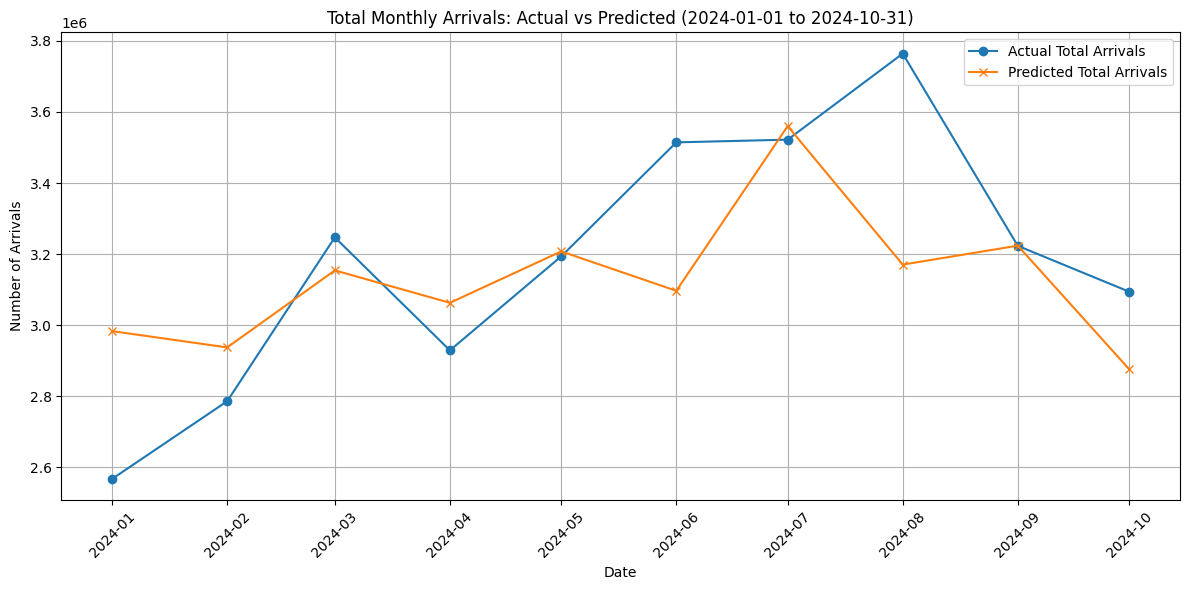


=== Evaluation Metrics ===
RMSE: 282510.38
MAE : 207546.33
Median AE      : 142575.55
MAPE: 6.53%
R² Score       : 0.3217
RMSLE           : 0.0889

=== Month-wise Actual vs Predicted Total Arrivals ===
Month  Actual_Arrivals  Predicted_Arrivals
  Jan        2567639.0             2983292
  Feb        2786137.0             2937499
  Mar        3247101.0             3154194
  Apr        2929205.0             3062994
  May        3193704.0             3207611
  Jun        3514361.0             3096773
  Jul        3521942.0             3560062
  Aug        3764066.0             3170453
  Sep        3223216.0             3223774
  Oct        3094268.0             2876301


In [ ]:
import lightgbm as lgb

# Create the model with best params
lgb_tuned = lgb.LGBMRegressor(subsample=0.6, num_leaves=31, n_estimators= 500,
min_child_samples=5, max_depth=10, learning_rate=0.03, colsample_bytree=0.8)

#lgb_tuned = lgb.LGBMRegressor(random_state=42, **search.best_params_)

# Model fitting
lgb_tuned.fit(X_train, y_train)

# Predicting arrivals
pred_log = lgb_tuned.predict(X_test)

print(">> Tuned LightGBM Model")
evaluate_and_plot(test_df, pred_log, y_test)

**Model 3 (SARIMA)**

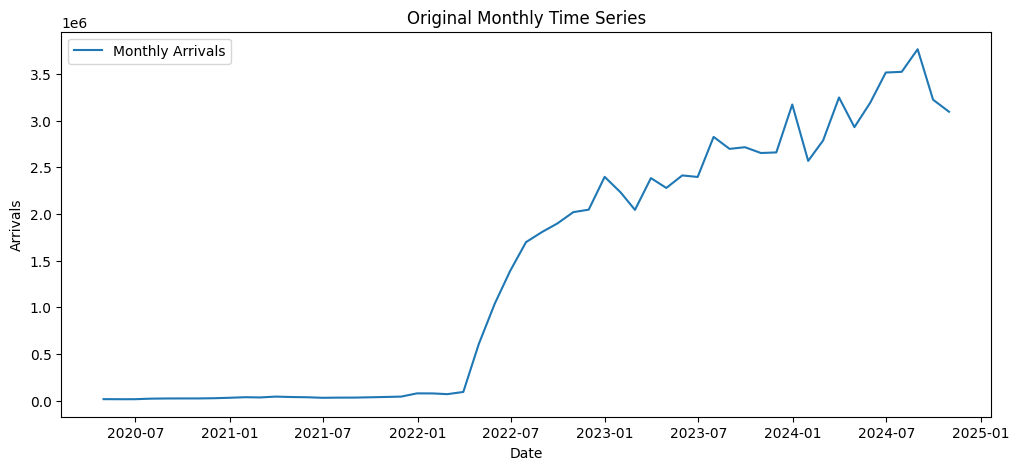

In [ ]:
# Prepare time series
df = df.set_index(pd.to_datetime(df['date']))
monthly_ts = df['arrivals'].resample('M').sum()

# Plot original time series
plt.figure(figsize=(12, 5))
plt.plot(monthly_ts, label='Monthly Arrivals')
plt.title('Original Monthly Time Series')
plt.xlabel('Date')
plt.ylabel('Arrivals')
plt.legend()
plt.show()

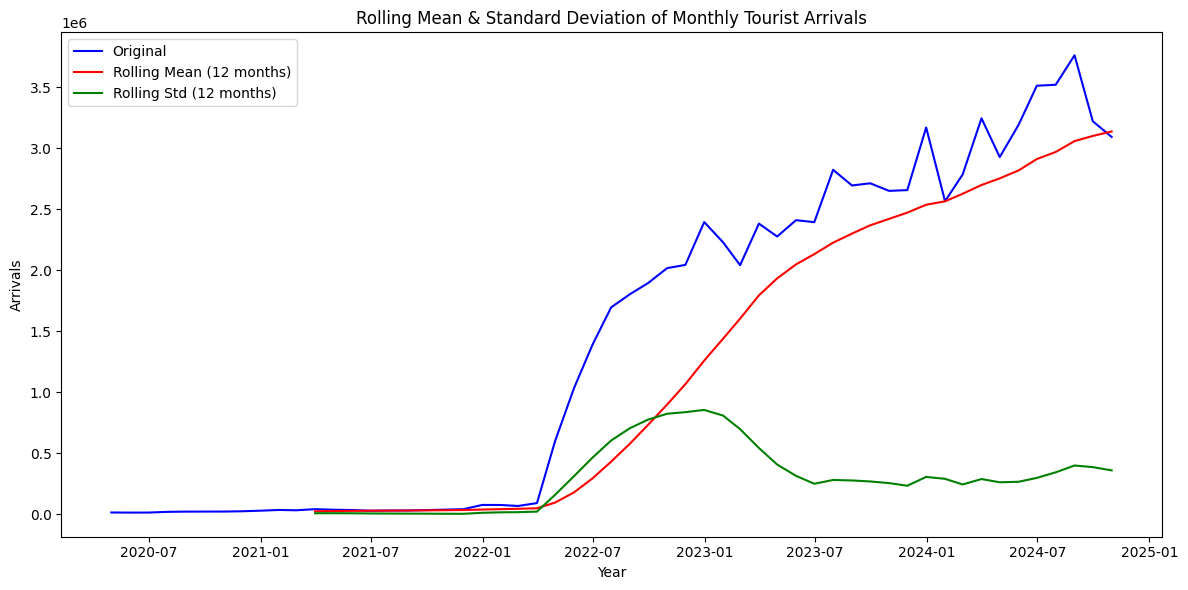

ADF Statistic: -0.62571063478702
p-value: 0.865066009967433
Critical Values 1%: -3.5925
Critical Values 5%: -2.9315
Critical Values 10%: -2.6041


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Plot rolling mean & std dev
rolling_mean = monthly_ts.rolling(window=12).mean()
rolling_std = monthly_ts.rolling(window=12).std()

# Show original dataset with rolling mean & rolling std
plt.figure(figsize=(12, 6))
plt.plot(monthly_ts, label='Original', color='blue')
plt.plot(rolling_mean, label='Rolling Mean (12 months)', color='red')
plt.plot(rolling_std, label='Rolling Std (12 months)', color='green')
plt.title('Rolling Mean & Standard Deviation of Monthly Tourist Arrivals')
plt.xlabel('Year')
plt.ylabel('Arrivals')
plt.legend()
plt.tight_layout()
plt.show()

# augmented dickey-fuller (ADF) test
# Check stationarity (not stationary, p>0.05)
adf_result = adfuller(monthly_ts.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f'Critical Values {key}: {value:.4f}')

ADF (1st diff): -1.354, p-value: 0.604
ADF (seasonal diff): -2.162, p-value: 0.220
ADF (first + seasonal): -1.928, p-value: 0.319


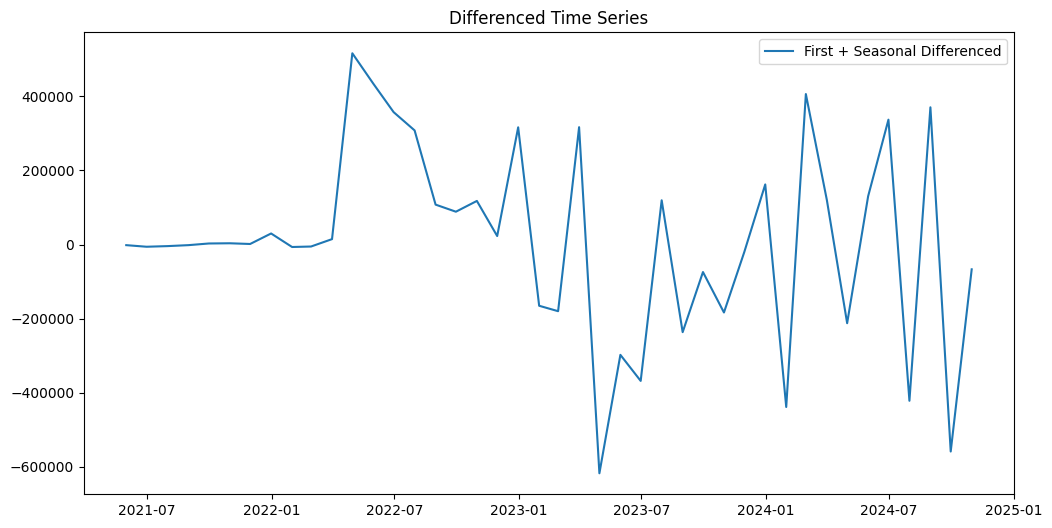

ADF Statistic (diff): -1.928
p-value (diff): 0.319
Critical Value 1%: -3.610
Critical Value 5%: -2.939
Critical Value 10%: -2.608


In [ ]:
# First order differencing (d=1)
diff_1 = monthly_ts.diff().dropna()
adf_result1 = adfuller(diff_1)
print(f"ADF (1st diff): {adf_result1[0]:.3f}, p-value: {adf_result1[1]:.3f}")

# Seasonal differencing (D=1, s=12)
diff_12 = monthly_ts.diff(12).dropna()
adf_result12 = adfuller(diff_12)
print(f"ADF (seasonal diff): {adf_result12[0]:.3f}, p-value: {adf_result12[1]:.3f}")

# First + Seasonal differencing (d=1, D=1)
diff_both = diff_1.diff(12).dropna()
adf_result_both = adfuller(diff_both.dropna())
print(f"ADF (first + seasonal): {adf_result_both[0]:.3f}, p-value: {adf_result_both[1]:.3f}")

# Plot differenced series (choose one based on ADF)
plt.figure(figsize=(12,6))
plt.plot(diff_both, label='First + Seasonal Differenced')
plt.title('Differenced Time Series')
plt.legend()
plt.show()

# ADF test on differenced data
adf_diff = adfuller(diff_both)
print(f"ADF Statistic (diff): {adf_diff[0]:.3f}")
print(f"p-value (diff): {adf_diff[1]:.3f}")
for key, value in adf_diff[4].items():
    print(f'Critical Value {key}: {value:.3f}')


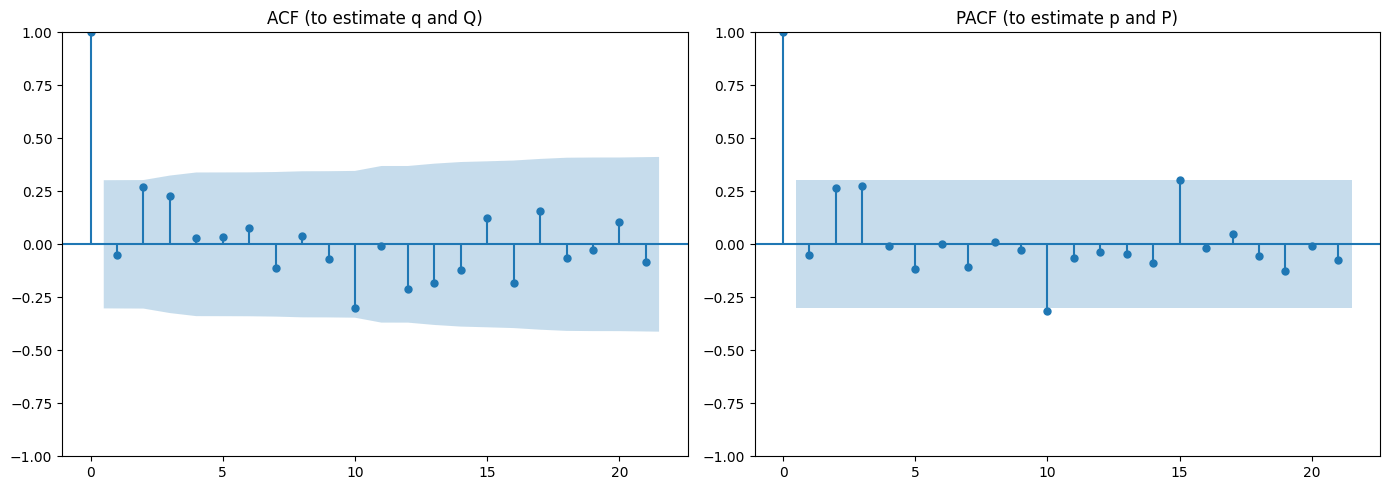

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plot_acf(diff_both, lags=21, ax=plt.gca())
plt.title('ACF (to estimate q and Q)')

plt.subplot(1,2,2)
plot_pacf(diff_both, lags=21, ax=plt.gca())
plt.title('PACF (to estimate p and P)')

plt.tight_layout()
plt.show()



*   Initial modelling without tuning with hyperparameters



>> Basic SARIMA Model


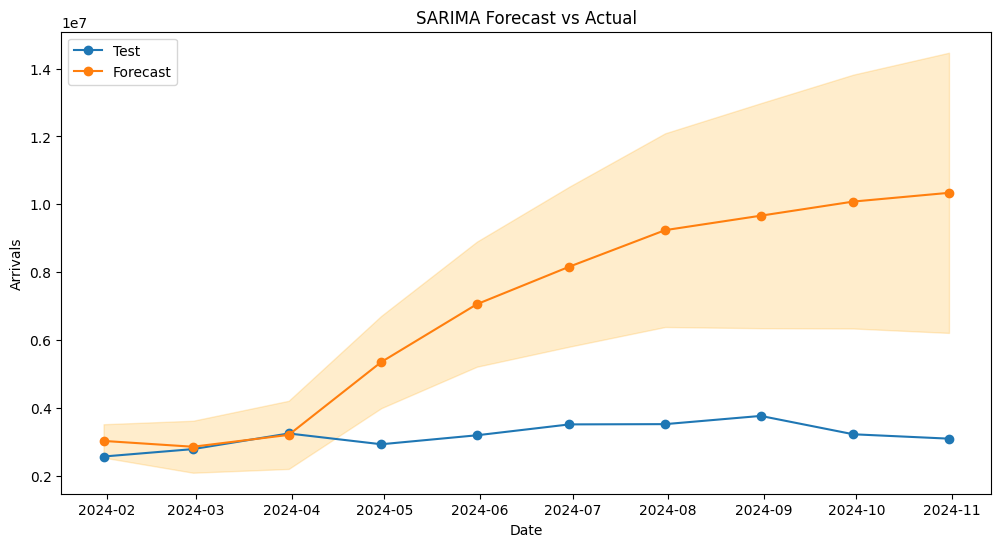

MAE: 3722092.38
RMSE: 4577938.90
Median AE: 4255707.92
MAPE: 112.35%
R²: -177.119
RMSLE: 0.794

Comparison Table:
   Month  Actual_Arrivals  Predicted_Arrivals
Jan 2024          2567639             3027506
Feb 2024          2786137             2855878
Mar 2024          3247101             3205330
Apr 2024          2929205             5351768
May 2024          3193704             7056466
Jun 2024          3514361             8163014
Jul 2024          3521942             9237722
Aug 2024          3764066             9663805
Sep 2024          3223216            10079953
Oct 2024          3094268            10337577


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, median_absolute_error

# Split train and test
train = monthly_ts[:'2023-12']
test = monthly_ts['2024-01':'2024-10']

# Fit SARIMA model with basic parameters, since dataset is non-stationary even after differencing
model = SARIMAX(train,
                order=(1,1,1),
                seasonal_order=(1,1,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

print(">> Basic SARIMA Model")

# Forecast
forecast = results.get_forecast(steps=len(test))
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Test',marker='o')
plt.plot(pred.index, pred, label='Forecast', marker='o')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], color='orange', alpha=0.2)
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Arrivals')
plt.legend()
plt.show()

# Calculate evaluation metrics
mae = mean_absolute_error(test, pred)
mse = mean_squared_error(test, pred)
rmse = np.sqrt(mse)
mape = (abs((test - pred) / test)).mean() * 100
r2 = r2_score(test, pred)
msle = mean_squared_log_error(test, pred)
rmsle = np.sqrt(msle)
medae = median_absolute_error(test, pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Median AE: {medae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.3f}")
print(f"RMSLE: {rmsle:.3f}")

# Comparison Table
comparison_df = pd.DataFrame({
    'Month': test.index.strftime('%b %Y'),
    'Actual_Arrivals': test.values,
    'Predicted_Arrivals': pred.values.round().astype(int)
})

print("\nComparison Table:")
print(comparison_df.to_string(index=False))


**Tuning SARIMA**

Tuning with hyperparameters and compare on AIC

>> Tuned SARIMA Model
Best SARIMA order: (1, 1, 2)
Best seasonal order: (0, 1, 1, 12)
Best AIC: 470.67

MAE: 204010.39
RMSE: 241911.27
Median AE: 221683.94
MAPE: 6.53%
R²: 0.503
RMSLE: 0.075


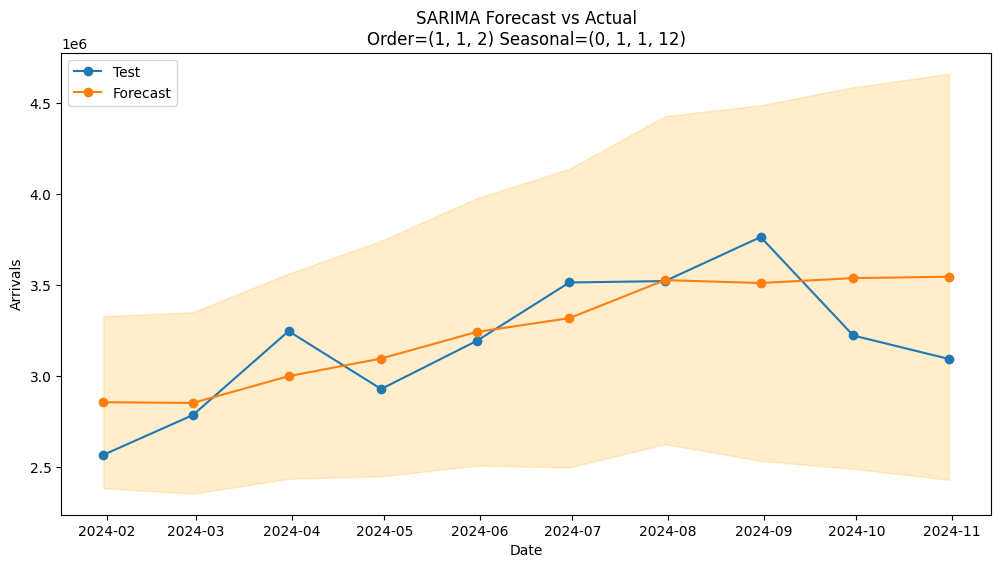


Comparison Table:
   Month  Actual_Arrivals  Predicted_Arrivals
Jan 2024          2567639             2856587
Feb 2024          2786137             2852561
Mar 2024          3247101             2999581
Apr 2024          2929205             3096529
May 2024          3193704             3242802
Jun 2024          3514361             3318513
Jul 2024          3521942             3527280
Aug 2024          3764066             3511421
Sep 2024          3223216             3538483
Oct 2024          3094268             3545960


In [ ]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Parameter ranges to try
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 12  # monthly data seasonality

best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

print(">> Tuned SARIMA Model")

for param in [(i,1,j) for i in p for j in q]:  # fix d=1
    for seasonal_param in [(I,1,J,s) for I in P for J in Q]:  # fix D=1
        try:
            model = SARIMAX(train,
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
                best_model = results
        except:
            continue

print(f'Best SARIMA order: {best_order}')
print(f'Best seasonal order: {best_seasonal_order}')
print(f'Best AIC: {best_aic:.2f}')

# Forecast using best model
forecast = best_model.get_forecast(steps=10)
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

# Calculate evaluation metrics
mae = mean_absolute_error(test, pred)
mse = mean_squared_error(test, pred)
rmse = np.sqrt(mse)
mape = (abs((test - pred) / test)).mean() * 100
r2 = r2_score(test, pred)
msle = mean_squared_log_error(test, pred)
rmsle = np.sqrt(msle)
medae = median_absolute_error(test, pred)

print(f"\nMAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Median AE: {medae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.3f}")
print(f"RMSLE: {rmsle:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Test', marker='o')
plt.plot(pred.index, pred, label='Forecast', marker='o')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], color='orange', alpha=0.2)

plt.title(f'SARIMA Forecast vs Actual\nOrder={best_order} Seasonal={best_seasonal_order}')
plt.xlabel('Date')
plt.ylabel('Arrivals')
plt.legend()
plt.show()

# Comparison Table
comparison_df = pd.DataFrame({
    'Month': test.index.strftime('%b %Y'),
    'Actual_Arrivals': test.values,
    'Predicted_Arrivals': pred.values.round().astype(int)
})

print("\nComparison Table:")
print(comparison_df.to_string(index=False))
